In [1]:
# enable auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import math

# 1. Two Moons 데이터 로드

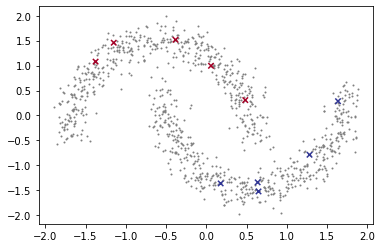

In [3]:
from src.utils.data_utils import TwoMoonDataset
dataset = TwoMoonDataset(1000,noise=(0.1,0.1),ratio=1,n_label=5)

X = dataset.X
y = dataset.y
M = dataset.M

plt.scatter(X[:,0],X[:,1],c='gray',s=1)
plt.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')
plt.show()

# 2. SSL Experiment

In [4]:
## Train configurations
LR0 = 0.01         ## learning rate
BATCH0 = 1000      ## batch size
EPOCH0 = 500      ## # of epochs to run
SAVE_PATH = './saved_models'  ## path to save model weights
LOG_PATH = './train_logs'  ## path to save train logs
TEST_PATH = './test_results'  ## path to save test results

## Make necessary directories
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
if not os.path.exists(TEST_PATH):
    os.mkdir(TEST_PATH)
    
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=BATCH0, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=BATCH0, shuffle=False)

## 2.1 Fully-Supervised Model

In [6]:
'''
    Define BaseModel, which is fully-supervised model in default
'''

class BaseModel(nn.Module):
    def __init__(self, model_name='tutorial_base_model',*args,**kwargs):
        '''
            [Input]
                - model_name : model name
        '''
        super(BaseModel, self).__init__(*args,**kwargs)
        self.name = model_name
        self.e=0        ## self.e : save current epoch
        
        ## Encoder : 2 FC layers with relu activation
        self.enc = nn.Sequential(
            nn.Linear(2,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU()
        )
        ## Decoder : 1 FC layer
        self.dec = nn.Linear(256,2)

        ## Save training logs
        self.total_train_loss=[]
        self.total_train_acc=[]
        
    def forward(self, x, label, mask):
        '''
            [Input]
                - x : batch of input data
                - label : ground-truth label
                - mask : mask_ij is True if x_ij is labeled, else False
            [Output]
                - pred : batch of predicted probabilities for each categories
                - loss : loss
                - z : latent vector
        '''
        z = self.enc(x)
        pred = self.dec(z)
        
        
        if mask.any():
            ## If labeled data exist, compute classification loss
            loss = nn.CrossEntropyLoss()(pred[mask],label[mask])
        else:
            ## If all data are unlabeled, do not compute classification loss
            loss=None
            
        return pred, loss, z
    
    def train_model(self, train_dataloader, epoch, optimizer,**kwargs):
        '''
            [Input]
                - train_dataloader : training dataloader to sample batch from
                - epoch : # of epochs to run
                - optimizer : optimizer
        '''
        best_eval=float('inf')
        
        while True:
            if self.e >= epoch:
                break
            ts = time.time()
            
            ## Train epoch step
            self.train()
            train_loss, train_acc = self.epoch_step(train_dataloader, optimizer=optimizer,**kwargs)
            self.total_train_loss.append(train_loss)
            self.total_train_acc.append(train_acc)
            
            if self.e%100 == 99:
                torch.save(self.state_dict(), './saved_models/%s_e%d.pth'%(self.name, self.e+1))
                pickle.dump((self.total_train_loss, self.total_train_acc), open('./train_logs/%s.bin'%(self.name),'wb'))
                print('(%.2fs) [Epoch %d]'%(time.time()-ts,self.e+1))
                print('\tTrain Loss : %.5f,\tTrain Acc : %.5f'%(train_loss, train_acc))
            self.e += 1
            
    def epoch_step(self, dataloader, optimizer=None, return_result=False,soft_pred=False, **kwargs):
        '''
            [Input]
                - dataloader : training dataloader to sample batch from
                - optimizer : optimizer
                - return_result : whether to return prediction result or not (for evaluation only)
                - soft_pred : wheter to return soft prediction or not (for evaluation only)
            [Output]
                - avg_loss : average loss of current epoch
                - accuracy : prediction accuracy of current epoch
        '''
        avg_loss = 0.0
        n=0
        total_correct=0
        total_z = []
        total_pred=[]
        
        ## For all data
        for batch, label, mask in dataloader:
            ## Upload to GPU
            batch=batch.cuda().to(dtype=torch.float)
            label=label.cuda().to(dtype=torch.long)
            mask = mask.cuda().to(dtype=torch.bool)
            
            ## Screen labels of unlabeled data
            masked_label = label.clone()
            masked_label[~mask] = -1
            
            ## Batch step
            loss, p, z = self.batch_step(batch, masked_label, mask, optimizer=optimizer,**kwargs)
            
            ## Get predicted labels from predicted probabilities
            pred = torch.argmax(p, dim=1)
            
            ## Update moving average of loss
            avg_loss = (n*avg_loss + loss.item()*batch.size(0)) / (n+batch.shape[0])
            n = n+batch.shape[0]
            
            correct = (label[label==pred]).shape[0]
            total_correct += correct
            total_z.append(z.detach().cpu())
            
            if soft_pred:
                ## If soft_pred is True, return predicted probabilities instead of predicted labels
                sp = F.softmax(p,dim=-1)
                total_pred.append(sp.detach().cpu())
            else:
                total_pred.append(pred.detach().cpu())
                
        if return_result:
            return avg_loss, total_correct/n, torch.cat(total_z), torch.cat(total_pred)
        return avg_loss, total_correct / n
    
    def batch_step(self, batch, label, mask, optimizer=None):
        '''
            [Input]
                - batch : batch of input data
                - label : ground-truth label
                - mask : mask_ij is True if x_ij is labeled, else False
                - optimizer : optimizer
            [Output]
                - loss : loss
                - p : batch of predicted probabilites for each categories
                - z : latent vector
        '''
        ## Forward pass
        p, loss, z = self.forward(batch, label, mask)
        
        ## Update model weight if training and loss is computed
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        if loss is None:
            loss = torch.tensor(0.0)

        return loss, p, z
    
    
    def predict(self, dataloader, soft_pred=False, **kwargs):
        '''
            [Input]
                - dataloader : dataloader to sample batches from
                - soft_pred : if True, return prediction for probabilities instead of prediction for labels
            [Output]
                - z : latent vectors
                - pred : predictions
        '''
        self.eval()
        with torch.no_grad():
            loss,acc,z,pred = self.epoch_step(dataloader,return_result=True,soft_pred=soft_pred,**kwargs)
        return z, pred
        

In [7]:
'''
    Train BaseModel
'''

## generate model
model = BaseModel()

## to cuda
model.cuda()

## Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LR0)

## train model
model.train_model(train_dataloader, EPOCH0, optimizer)

(0.01s) [Epoch 100]
	Train Loss : 0.00000,	Train Acc : 0.87100
(0.01s) [Epoch 200]
	Train Loss : 0.00000,	Train Acc : 0.87100
(0.01s) [Epoch 300]
	Train Loss : 0.00000,	Train Acc : 0.87100
(0.01s) [Epoch 400]
	Train Loss : 0.00000,	Train Acc : 0.87100
(0.01s) [Epoch 500]
	Train Loss : 0.00000,	Train Acc : 0.87100


In [8]:
'''
    Define grid dataset
'''
a=np.linspace(-2.5,2.5,100)
x_grid,y_grid = np.meshgrid(a,a)
x_grid=x_grid.reshape(-1)
y_grid=y_grid.reshape(-1)

grid_dataloader = DataLoader([(torch.tensor([x_grid[i],y_grid[i]]),0,True) for i in range(x_grid.shape[0])], batch_size=BATCH0)

[Epoch 100]


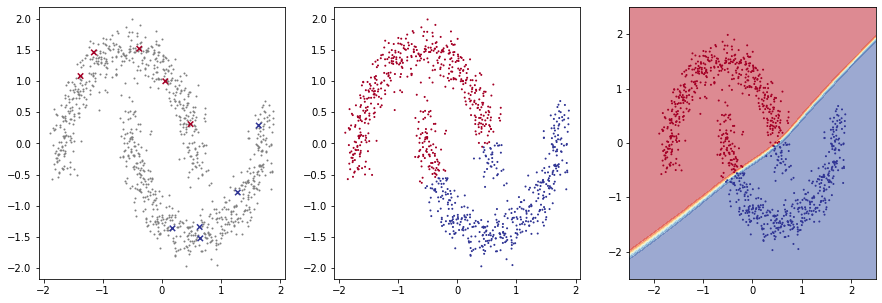

[Epoch 200]


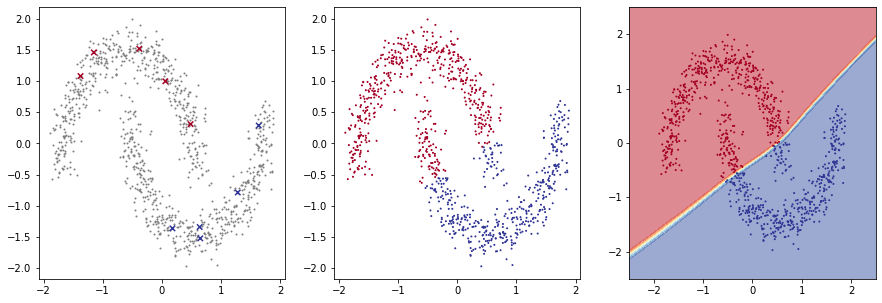

[Epoch 300]


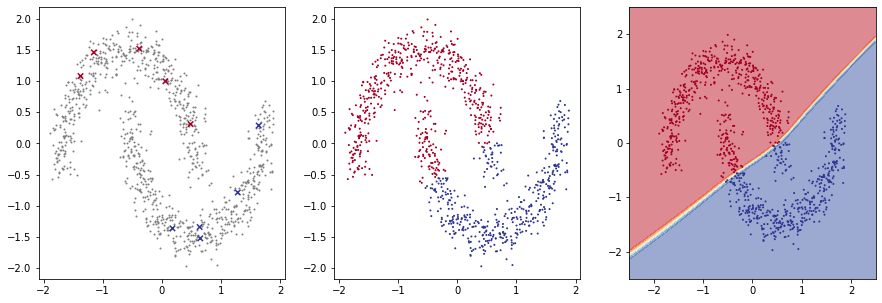

[Epoch 400]


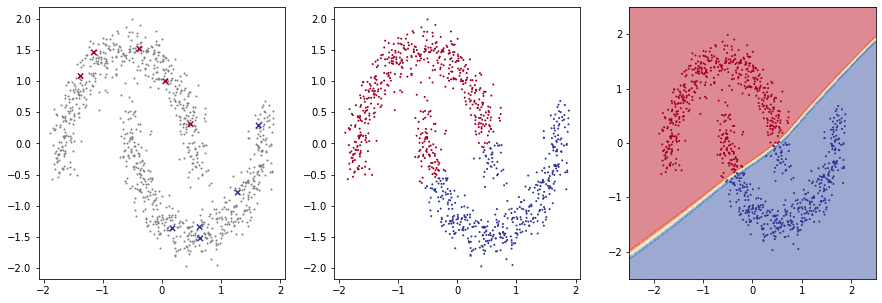

[Epoch 500]


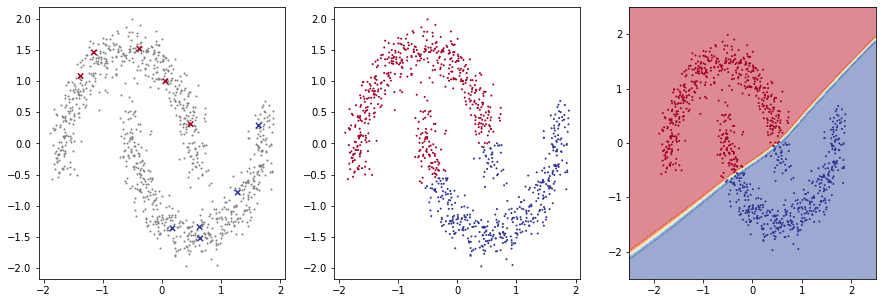

In [9]:
'''
    Plot preditions over epochs
'''
FROM = 100
TO = 500
INTV = 100

for e in range(FROM,TO+1,INTV):
    model = BaseModel()
    model.load_state_dict(torch.load('./saved_models/tutorial_base_model_e%d.pth'%e))
    print('[Epoch %d]'%e)
    model.cuda()
    z,pred=model.predict(test_dataloader)
    _,pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = dataset.X
    y = dataset.y
    M = dataset.M

    fig=plt.figure(figsize=(15,5))
    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()

## 2.2 Pi-Model

In [10]:
def CrossEntropy(q,p):
    '''
        [Input]
            - q : input
            - p : target
        [Output]
            - CrossEntropy(q||p)
    '''
    b = F.softmax(p, dim=1) * F.log_softmax(q, dim=1)
    b = -1.0*b.mean()
    return b

def perturb(data, sig=0.15):
    '''
        [Input]
            - data : original data
            - sig : std of noise
        [Output]
            - perturbed data
    '''
    eps = torch.randn(data.size()).to(device=data.device)
    return data+eps*sig

class PiModel(BaseModel):
    def __init__(self, model_name='tutorial_pi_model',*args,**kwargs):
        super(PiModel, self).__init__(model_name=model_name, *args, **kwargs)
    def batch_step(self, batch, label, mask, optimizer=None):
        ## If model is on evaluation, use original data for prediction instead of perturbed data
        if self.training:
            batch_original = perturb(batch)
        else:
            batch_original = batch
        
        batch_perturbed = perturb(batch)
        
        ## Forward pass for student model
        p_original, loss, z = self.forward(batch_original, label, mask)
        
        ## Forward pass for teacher model
        with torch.no_grad():
            p_perturbed, _,_ = self.forward(batch_perturbed, label, mask)
        
        ## Distance metric : cross entropy / MSE / KLD
        dist_loss = CrossEntropy(p_original, p_perturbed)
        #dist_loss = nn.MSELoss()(p_original, p_perturbed)
        #dist_loss = F.kl_div(p_original, p_perturbed, reduction='batchmean')
        
        if loss is None:
            loss = torch.tensor(0.0)
        
        loss = loss+dist_loss

        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.loss = torch.tensor(0.0).cuda()
        if loss is None:
            loss = torch.tensor(0.0)
        return loss, p_original, z

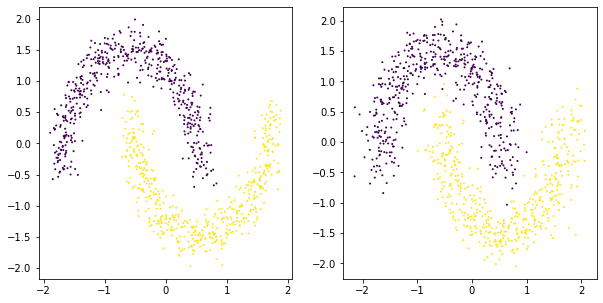

In [11]:
X = dataset.X
y = dataset.y
M = dataset.M

X_perturb=perturb(torch.tensor(X),sig=0.15)

fig=plt.figure(figsize=(10,5))
ax0 = plt.subplot(121)
ax0.scatter(X[:,0],X[:,1],c=y,s=1)
ax1 = plt.subplot(122)
ax1.scatter(X_perturb[:,0],X_perturb[:,1],c=y,s=1)
plt.show()

In [12]:
## train Pi-model
model = PiModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR0)

model.train_model(train_dataloader, EPOCH0, optimizer)

(0.01s) [Epoch 100]
	Train Loss : 0.07530,	Train Acc : 0.92700
(0.01s) [Epoch 200]
	Train Loss : 0.07866,	Train Acc : 0.90400
(0.01s) [Epoch 300]
	Train Loss : 0.06743,	Train Acc : 0.91800
(0.01s) [Epoch 400]
	Train Loss : 0.07394,	Train Acc : 0.91200
(0.02s) [Epoch 500]
	Train Loss : 0.07318,	Train Acc : 0.90500


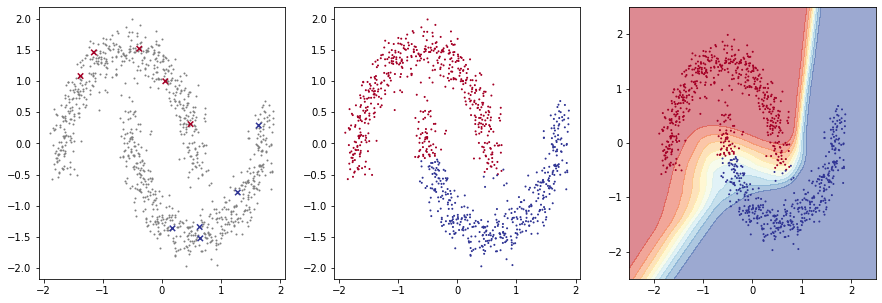

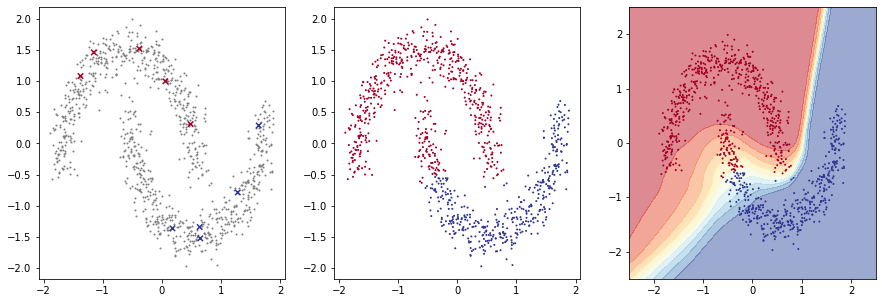

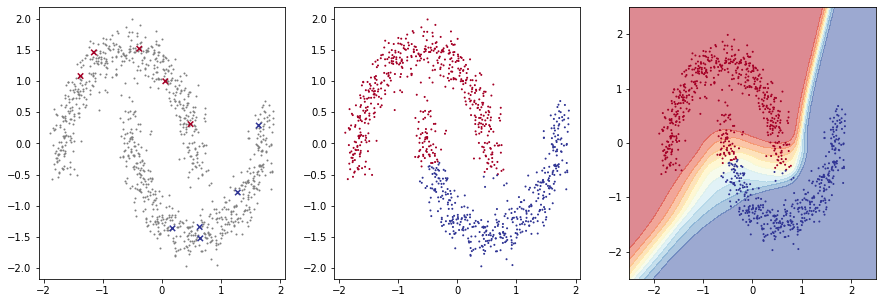

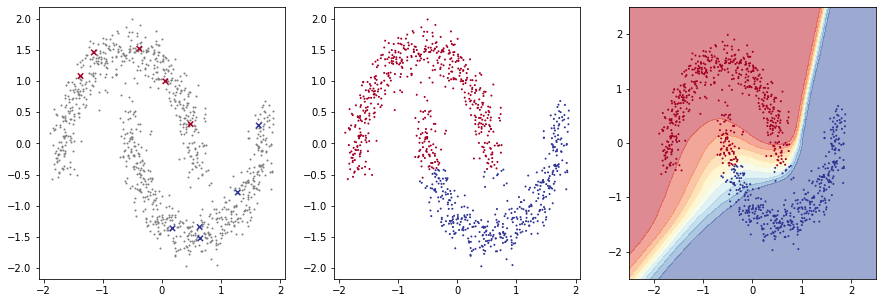

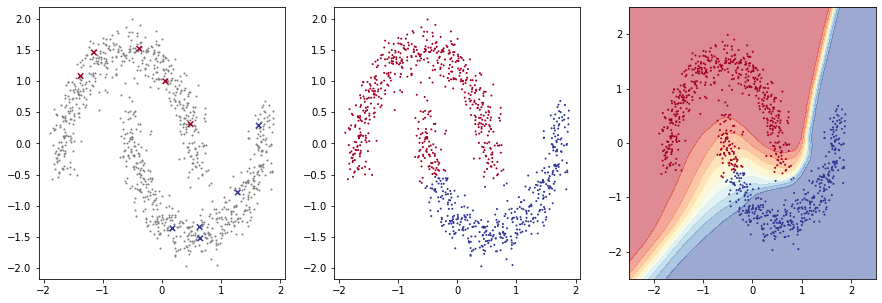

In [13]:

FROM = 100
TO = 500
INTV = 100

for e in range(FROM,TO+1,INTV):
    model = PiModel()
    model.load_state_dict(torch.load('./saved_models/tutorial_pi_model_e%d.pth'%e))
    model.cuda()
    z,pred=model.predict(test_dataloader)
    _,pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = dataset.X
    y = dataset.y
    M = dataset.M

    fig=plt.figure(figsize=(15,5))

    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()

## 2.3 Mean Teacher

In [14]:
class MTModel(BaseModel):
    def __init__(self, model_name='tutorial_mt_model',alpha=0.5,rampup=False,*args,**kwargs):
        super(MTModel, self).__init__(model_name=model_name, *args, **kwargs)
        '''
            [Input]
                - model_name : model_name
                - alpha : update ratio for EMA of parameters
                - rampup : if True, use ramp-up strategy
        '''
        self.alpha=alpha
        
        ## Make Teacher model, which has identical architecture with student model
        self.teacher = [BaseModel(*args,**kwargs)]
        
        ## Initially, copy parameters of student model into teacher model
        for param_t, param in zip(self.teacher[0].parameters(), self.parameters()):
            param_t.data = param.data
        
        ## We do not train teacher model, so turn off gradients
        self.teacher[0].requires_grad_(False)
        self.teacher[0].cuda()
        
        self.ramp=0.0 if rampup else 1.0
        self.rampup=rampup
        
    def batch_step(self, batch, label, mask, optimizer=None):
        ## If model is on evaluation, use original data for prediction instead of perturbed data
        if self.training:
            batch_original = perturb(batch)
        else:
            batch_original = batch
        
        batch_perturbed = perturb(batch)
        
        ## Forward pass for student model
        p_original, loss, z_original = self.forward(batch_original, label, mask)
        
        ## Forward pass for teacher model
        with torch.no_grad():
            p_perturbed, _,z_perturbed = self.teacher[0].forward(batch_perturbed, label, mask)
        
        
        ## Distance metric : cross entropy / MSE / KLD
        dist_loss = CrossEntropy(p_original, p_perturbed)
        #dist_loss = nn.MSELoss()(p_original, p_perturbed)
        #dist_loss = F.kl_div(p_original, p_perturbed, reduction='batchmean')
        
        if loss is None:
            loss = torch.tensor(0.0)
        loss = loss + self.ramp*dist_loss
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        ## Update parameters of teacher model as EMA of parameters of student model
        self.update_ema()
        
        if self.rampup:
            ## If rampup, update coefficient
            self.update_ramp()
        return loss, p_original, z_original
    
    def update_ema(self):
        '''
            Update teacher model parameters as EMA of student model
        '''
        ## alpha : coefficient for EMA
        alpha = self.alpha
        
        ## param_t : teacher parameter
        ## param : student parameter
        for param_t, param in zip(self.teacher[0].parameters(), self.parameters()):
            ## param_t <- alpha*param_t + (1-alpha)*param
            param_t.data.mul_(alpha).add_(1-alpha, param.data)
            
    def update_ramp(self, end_e=100):
        if self.e > end_e:
            self.ramp=1
        else:
            T = float(self.e)/float(end_e)
            self.ramp = (math.exp(-5.0*(1.0-T)*(1.0-T)))

In [15]:
## generate our model
model = MTModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR0)

model.train_model(train_dataloader, EPOCH0, optimizer)

d:\users\jh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:76: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)


(0.01s) [Epoch 100]
	Train Loss : 0.07668,	Train Acc : 0.91200
(0.02s) [Epoch 200]
	Train Loss : 0.08044,	Train Acc : 0.91100
(0.01s) [Epoch 300]
	Train Loss : 0.08738,	Train Acc : 0.92800
(0.01s) [Epoch 400]
	Train Loss : 0.08028,	Train Acc : 0.89700
(0.01s) [Epoch 500]
	Train Loss : 0.07751,	Train Acc : 0.91600


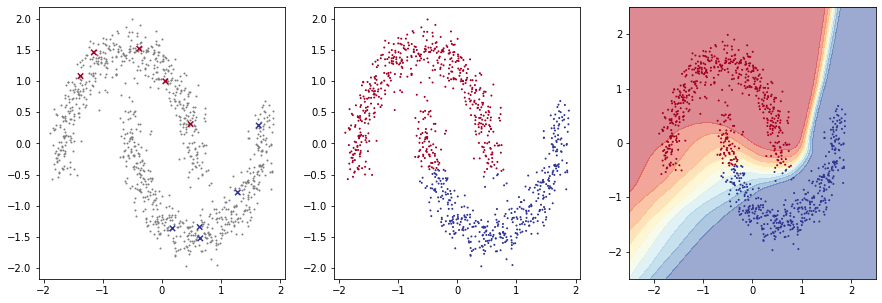

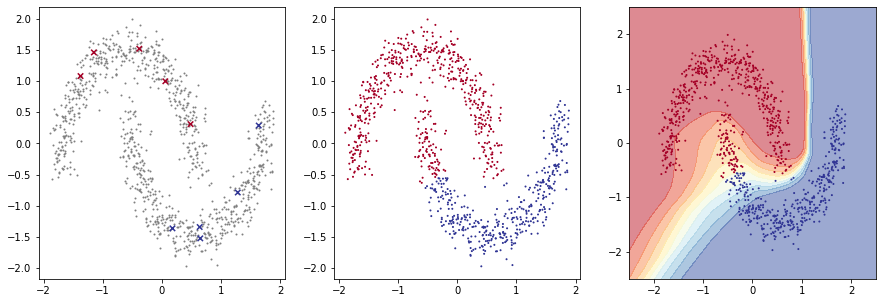

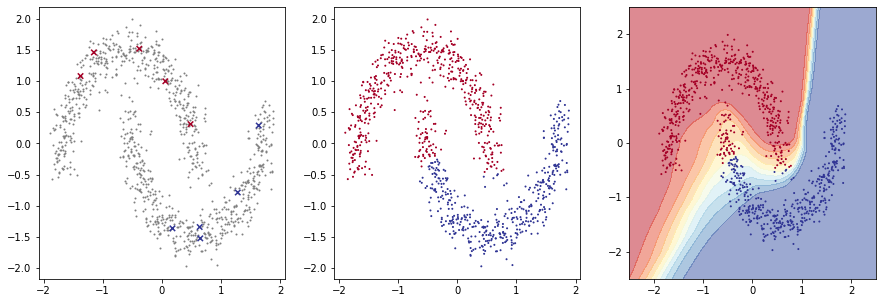

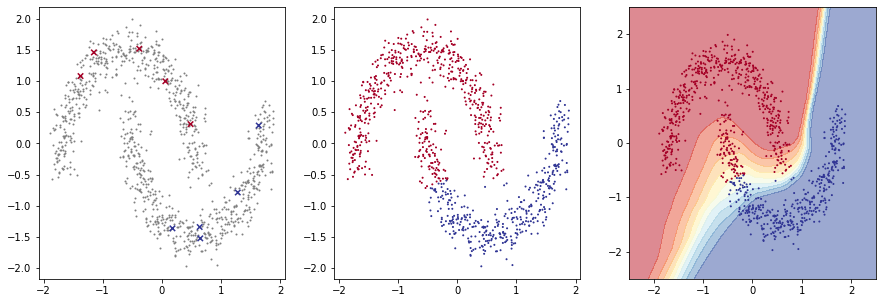

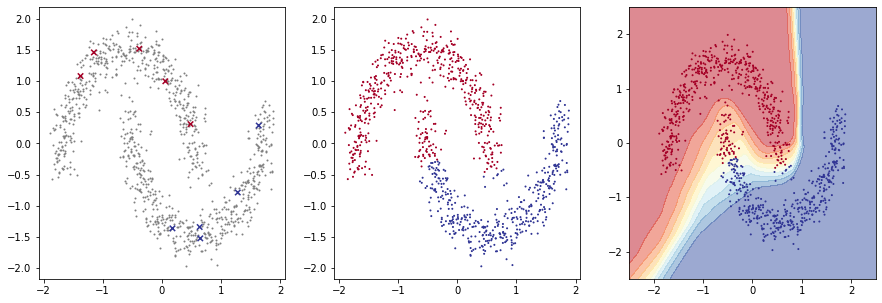

In [16]:

FROM = 100
TO = 500
INTV = 100

for e in range(FROM,TO+1,INTV):
    model = MTModel()
    model.load_state_dict(torch.load('./saved_models/tutorial_mt_model_e%d.pth'%e))
    model.cuda()
    z,pred=model.predict(test_dataloader)
    _,pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = dataset.X
    y = dataset.y
    M = dataset.M

    fig=plt.figure(figsize=(15,5))

    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()

## 2.4 Virtual Adversarial Training

In [17]:
class VATModel(BaseModel):
    def __init__(self, model_name='tutorial_vat_model',xi=1e-2,eps=0.1,*args,**kwargs):
        '''
            [Input]
                - model_name : model name
                - xi : scale of r0
                - eps : scale of r_adv
        '''
        super(VATModel, self).__init__(model_name=model_name, *args, **kwargs)
        self.xi=xi
        self.eps=eps
    def compute_lds(self,batch,label,mask,k=1):
        '''
            Compute Local Distribution Smoothness(LDS)
            [Input]
                - batch : input batch
                - label : ground-truth label
                - mask : mask_ij is True of x_ij is labeled, else False
                - k : # of iteration
            [Output]
                - LDS loss
        '''
        
        ## Get initial prediction probability (without computing gradient)
        with torch.no_grad():
            p, loss, _ = self.forward(batch, label, mask)
            p = F.log_softmax(p,dim=-1)
            
        ## randomly define r0
        r0 = torch.rand(batch.shape).sub(0.5).to(batch.device)
        ## r0 should be L2 normalized
        r0 = r0/(torch.norm(r0, dim=-1, keepdim=True)+1e-8)
        
        ## update r for k iterations
        for i in range(k):
            ## enable gradients for r0
            r0.requires_grad_()
            
            ## get batch applied noise r0
            batch_perturb = batch + r0*self.xi
            
            ## Forward pass to get perturbed prediction
            pred_hat, _, _ = self.forward(batch_perturb, label, mask)
            logp_hat = F.log_softmax(pred_hat, dim=-1)
            
            ## dist : KLD(p_perturb || p_original)
            dist = F.kl_div(logp_hat, p, reduction='batchmean', log_target=True)
            
            ## using backward() function in pytorch, we can easily compute gradient of r0
            dist.backward()
            ## new r0 : gradient of r0 (l2 normalized)
            r0 = r0.grad
            r0 = r0/(torch.norm(r0,dim=-1,keepdim=True)+1e-8)
            
            ## reset gradient
            self.zero_grad()
        r_adv = r0
        
        ## get batc applied noise r_adv
        batch_perturb = batch + r_adv*self.eps
        
        ## Forward pass and compute distance between original prediction and perturbed prediction
        pred_hat, _, _ = self.forward(batch_perturb, label, mask)
        logp_hat = F.log_softmax(pred_hat, dim=-1)
        lds = F.kl_div(logp_hat, p, reduction='batchmean', log_target=True)
        return lds
    def batch_step(self, batch, label, mask, optimizer=None, k=1):
        ## if model is on evaluation, torch.no_grad() is applied so we cannot compute LDS using backward() function
        ## because evaluation loss value is not our focus, skip computing LDS on evaluation
        if self.training:
            lds = self.compute_lds(batch,label,mask,k=k)
        else:
            lds = torch.tensor(0.0)
        
        ## Forward pass to compute classification loss
        p_original, loss, z_original = self.forward(batch, label, mask)

        if loss is None:
            loss = torch.tensor(0.0)
        loss = loss+lds
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        return loss, p_original, z_original

In [18]:
## generate our model
model = VATModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR0)

model.train_model(train_dataloader, EPOCH0, optimizer)

(0.02s) [Epoch 100]
	Train Loss : 0.00342,	Train Acc : 0.95500
(0.01s) [Epoch 200]
	Train Loss : 0.00168,	Train Acc : 0.99700
(0.01s) [Epoch 300]
	Train Loss : 0.00178,	Train Acc : 0.99900
(0.02s) [Epoch 400]
	Train Loss : 0.00282,	Train Acc : 0.99900
(0.01s) [Epoch 500]
	Train Loss : 0.00133,	Train Acc : 0.99900


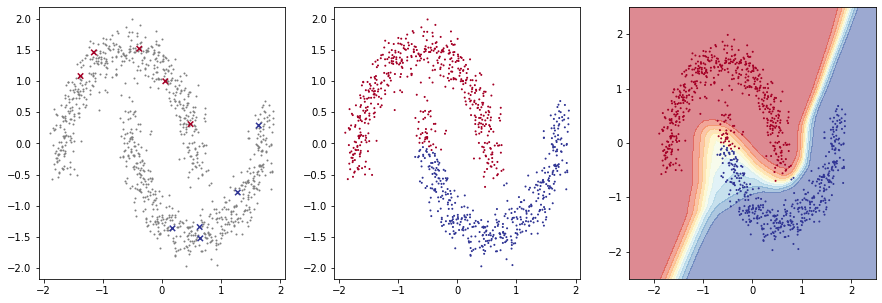

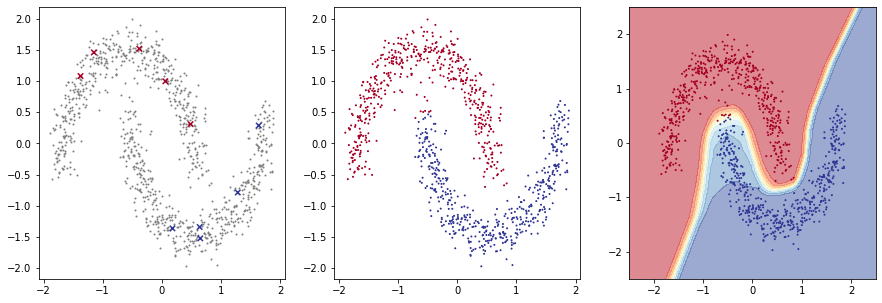

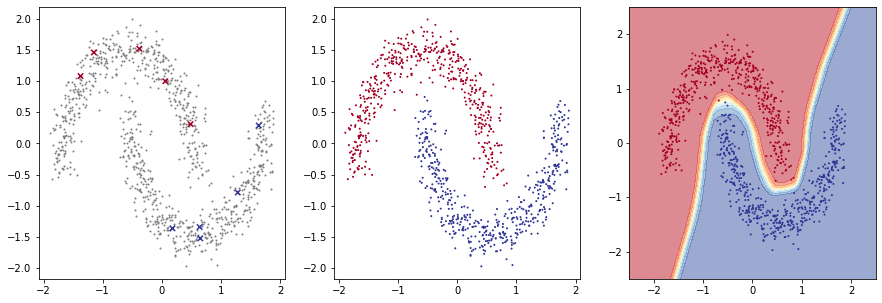

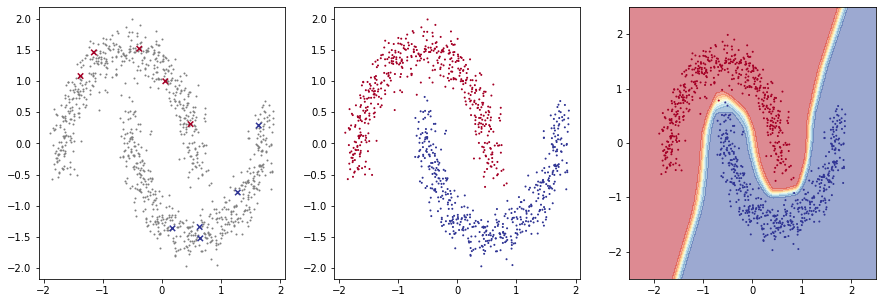

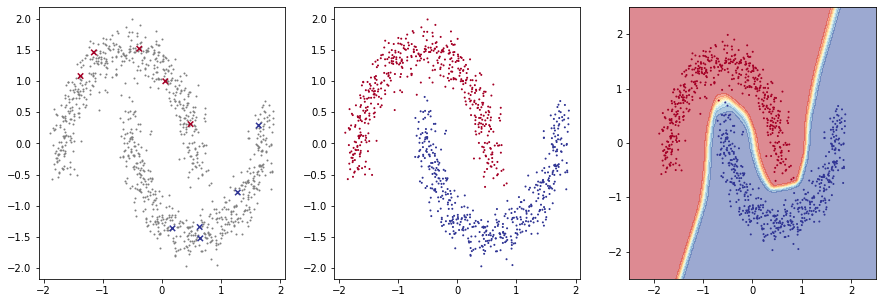

In [19]:

FROM = 100
TO = 500
INTV = 100

for e in range(FROM,TO+1,INTV):
    model = VATModel()
    model.load_state_dict(torch.load('./saved_models/tutorial_vat_model_e%d.pth'%e))
    model.cuda()
    z,pred=model.predict(test_dataloader)
    _,pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = dataset.X
    y = dataset.y
    M = dataset.M

    fig=plt.figure(figsize=(15,5))

    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()